### 0. Importing modules and data

In [92]:
import pandas as pd
import myEDA.MyEDA as EDA
import os

In [93]:
raw_df = pd.read_csv('../data/raw/MedicalIns.csv')
raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 1. Objective
Estimate the charges that a client have to pay to the medical insurance based on the characteristics collected in the dataset. So the target is the variable 'charges'.

### 2.Exploration and superficial cleaning

In [94]:
categorical, numerical = EDA.explore(raw_df)

Rows: 1338
Columns: 7
+----------+----------------+------------+-----------+---------------+
|          | Non-Null Count | Null Count | Data Type | Data Category |
+----------+----------------+------------+-----------+---------------+
|   age    |      1338      |     0      |   int64   |    Numeric    |
|   sex    |      1338      |     0      |  object   |  Categorical  |
|   bmi    |      1338      |     0      |  float64  |    Numeric    |
| children |      1338      |     0      |   int64   |    Numeric    |
|  smoker  |      1338      |     0      |  object   |  Categorical  |
|  region  |      1338      |     0      |  object   |  Categorical  |
| charges  |      1338      |     0      |  float64  |    Numeric    |
+----------+----------------+------------+-----------+---------------+


The dataset has no null values, and we cannot search for duplicates as we do not have any identification column.

#### 2.1 Get a preliminary view of the distribution of values of the target

<Axes: xlabel='charges', ylabel='Density'>

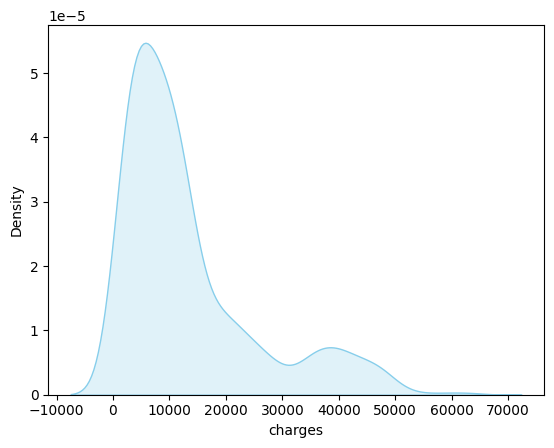

In [95]:
import seaborn as sns
sns.kdeplot(data=raw_df['charges'], color='skyblue', fill=True)

Negative values and zeros in the price that customers must pay makes no sense. Make shure that there are no erroneus data

In [96]:
# Check how many rows have charge=0
print('Charge=0:',(raw_df['charges'] == 0).sum())

# Check how many rows have charge<0
print('Charge<0:',(raw_df['charges'] < 0).sum())

Charge=0: 0
Charge<0: 0


#### 2.2 Drop unuseful information
In this case, I don't see any irrelevant information

### 3. Univariate analysis

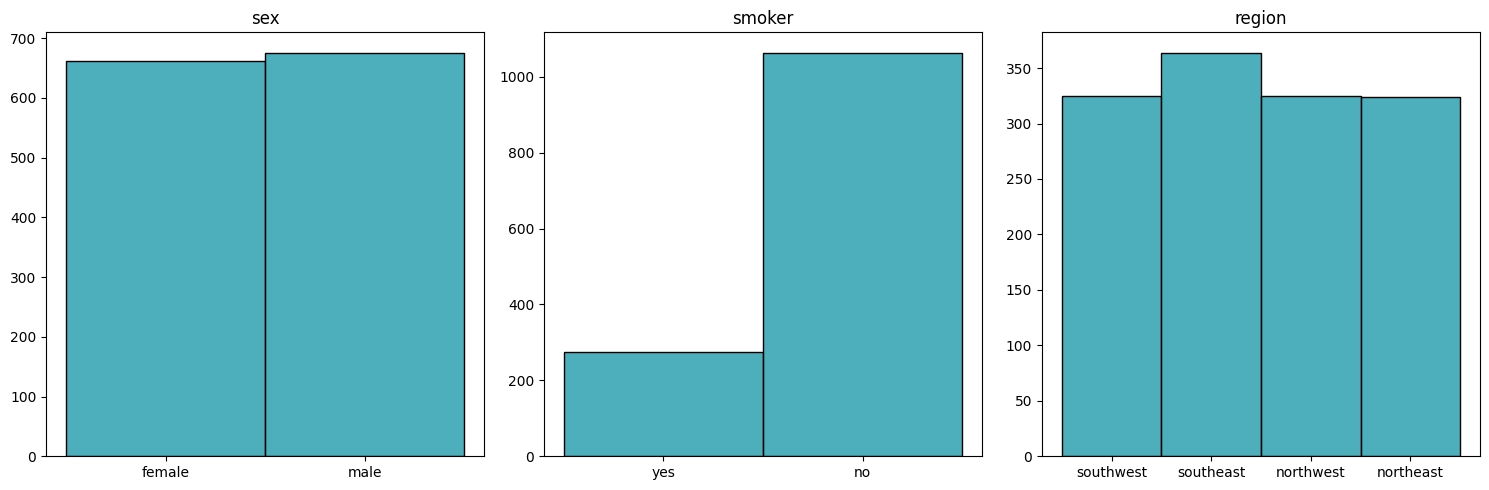

In [97]:
EDA.univariate_hist(categorical, raw_df)

As for age and region, the data is uniformly distributed across the categories, however, we see many more non-smokers than smokers. This could introduce bias into our model.

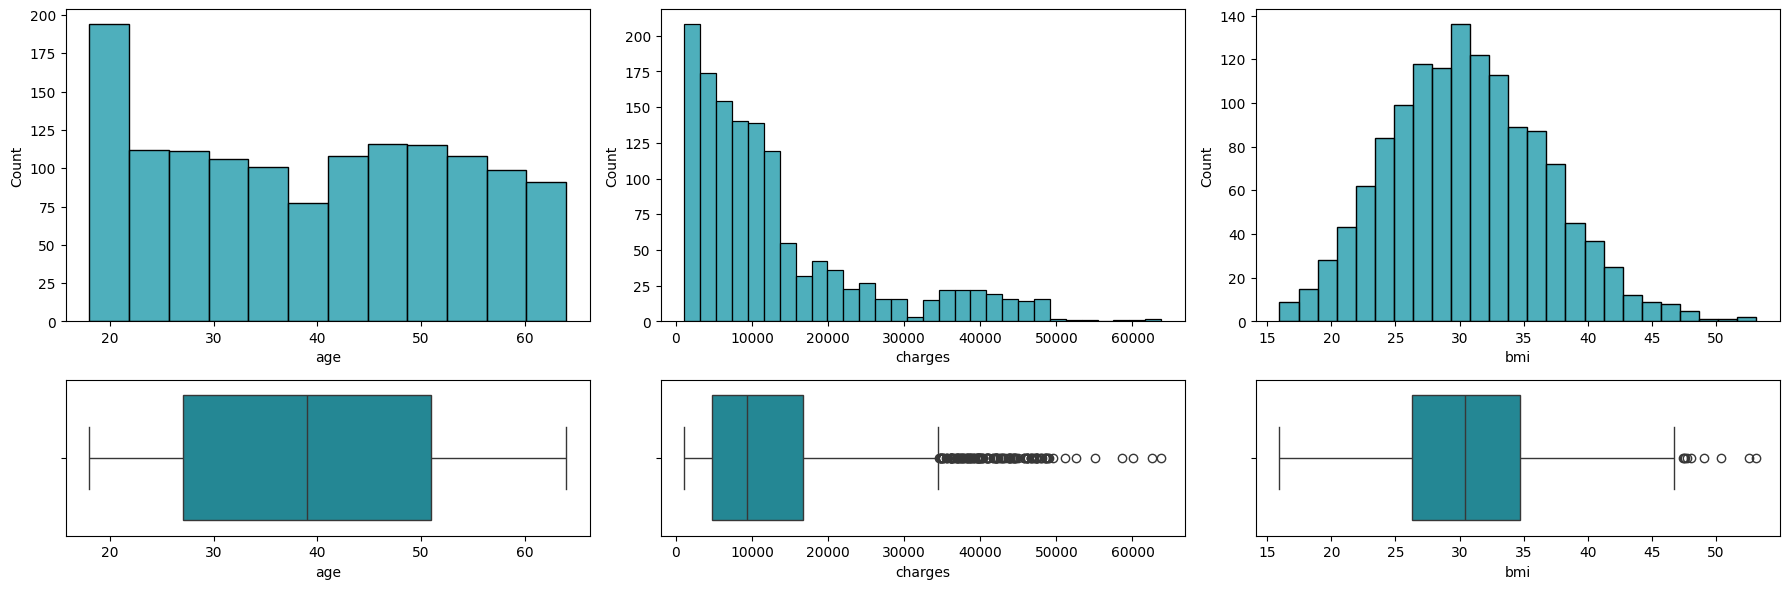

In [98]:
EDA.univariate_histbox(['age','charges','bmi'],raw_df)

The age distribution is also uniform. The distribution of BMI is very close to normal, except for some outliers that we can replace with the mean later. The distribution of charges is clearly asymmetric, so the outliers should be replaced by the mode later on. It is interesting to extract the data for the highest prices to see if they have any special common characteristics

In [99]:
hight_charges =  raw_df[raw_df['charges'] > 50000]
print(hight_charges.shape)
hight_charges

(7, 7)


,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [100]:
print('Smokers:',(raw_df['smoker'] == 'yes').sum())
print('High bmi:',(raw_df['bmi'] >30).sum())
print('Older than 30:',(raw_df['age'] >30).sum())
print('Smokers and high bmi:', ((raw_df['smoker'] == 'yes') & (raw_df['bmi'] > 30)).sum())

Smokers: 274
High bmi: 705
Older than 30: 894
Smokers and high bmi: 144


All customers with high prices are smokers and have above-average BMI, but they are not the only ones, so we cannot determine from this analysis why they have such a high price.

### 4. Multivariate analisis

In [101]:
def assign_value(var):
    return (5 if var >= 0 and var <= 10 else
            15 if var > 10 and var <= 20 else
            25 if var > 20 and var <= 30 else
            35 if var > 30 and var <= 40 else
            45 if var > 40 and var <= 50 else
            55 if var > 50 and var <= 60 else
            65 if var > 60 and var <= 70 else
            75 if var > 70 and var <= 80 else
            85 if var > 80 and var <= 90 else
            95 if var > 90 and var <= 1000 else
            105)

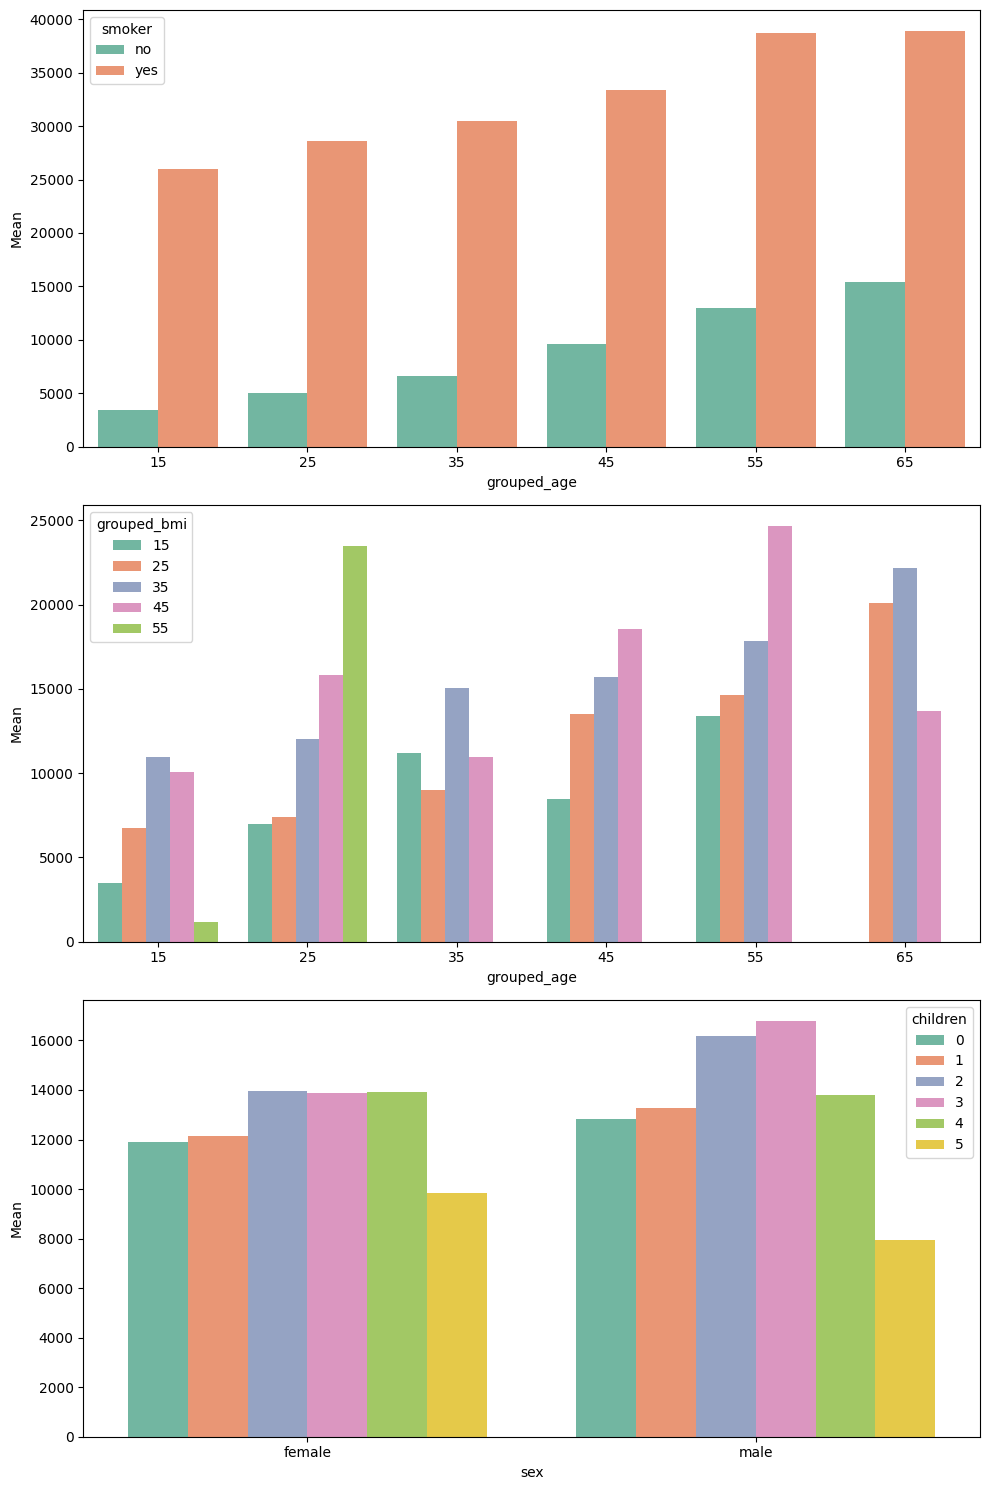

In [102]:
copy = raw_df.copy()
copy['grouped_age'] = copy['age'].apply(assign_value)
copy['grouped_bmi'] = copy['bmi'].apply(assign_value)

variable_lists=[['grouped_age','charges','smoker'],['grouped_age','charges','grouped_bmi'],['sex','charges','children']]
EDA.multivariate_barplots(copy, variable_lists,y_='mean')

The price is much higher for smokers and increases with age. Higher BMIs also have higher prices, but age is not relevant after 25. Having children does not penalize based on the client's gender

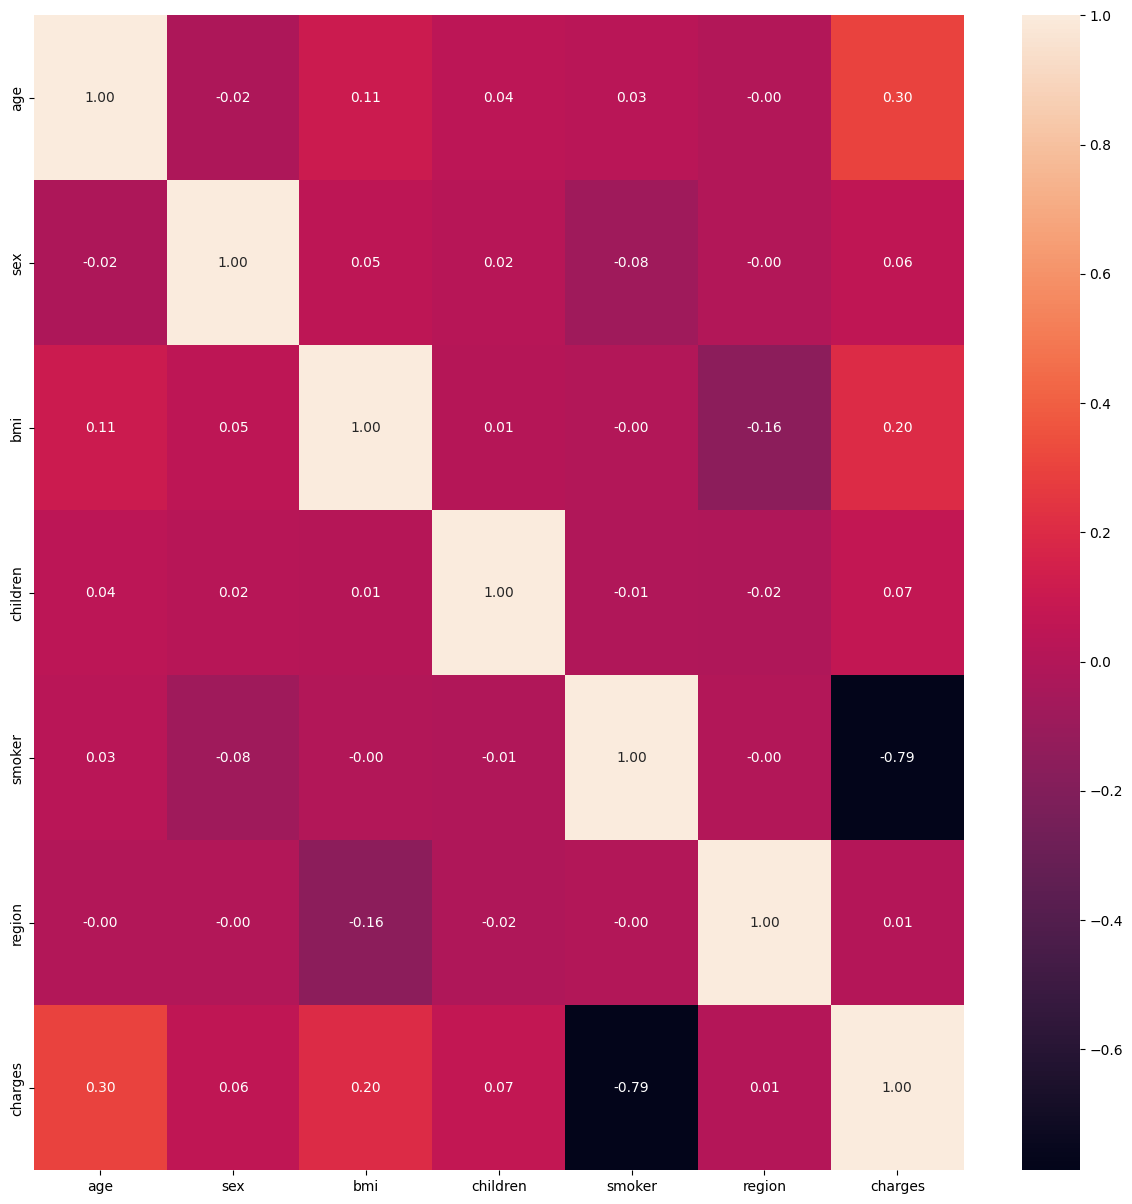

In [103]:
EDA.correlation_matrix(raw_df, categorical)

The correlation matrix indicates what we have previously seen, the most determining factors for the price of medical insurance are age, BMI, and smoking status. Gender, region, and children seem irrelevant. There appears to be a mild correlation between region and BMI. In feature selection, we can leave 4 variables

In [104]:
raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


### 5. Feature engineering
#### 5.1 Outliers

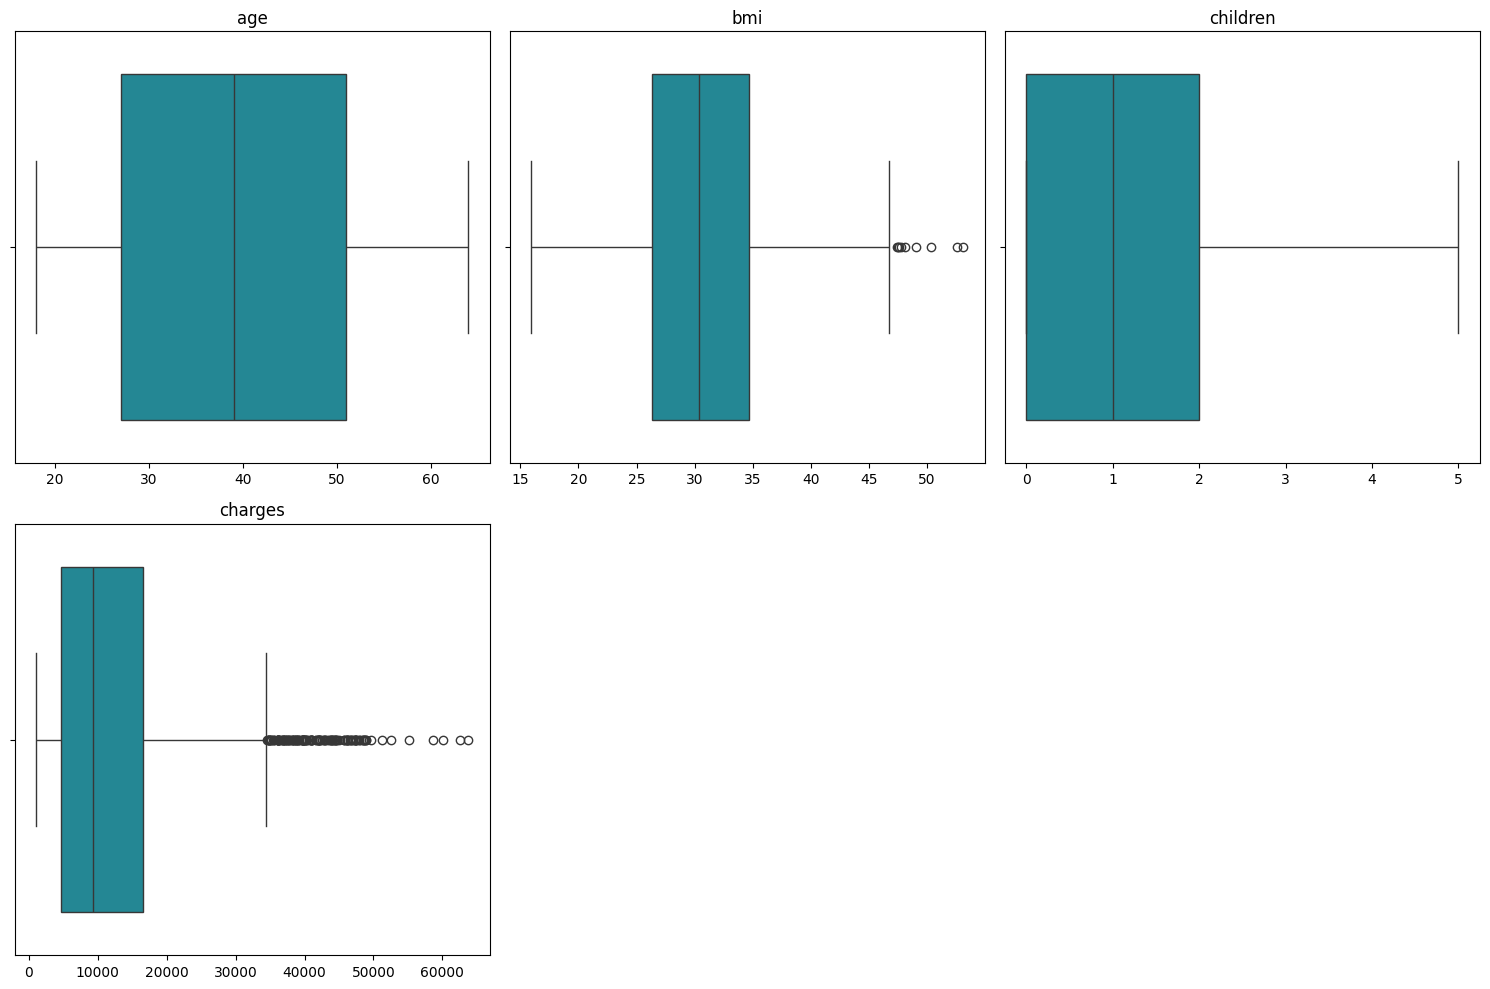

In [105]:
EDA.numerical_box(numerical, raw_df)

Let's search for outliers with bmi out of a iqr with sigma= 1

In [106]:
out, new =EDA.outliers_iqr(raw_df,'bmi',1,Do='nothing')

43.09125 17.89875
47 outliers have been found


In [107]:
out

,age,sex,bmi,children,smoker,region,charges
28,23,1,17.385,1,1,2,2775.19215
116,58,1,49.060,0,1,1,11381.32540
128,32,0,17.765,2,0,2,32734.18630
172,18,1,15.960,0,1,3,1694.79640
232,19,0,17.800,0,1,0,1727.78500
250,18,1,17.290,2,0,3,12829.45510
286,46,0,48.070,2,1,3,9432.92530
292,25,1,45.540,2,0,1,42112.23560
356,46,1,43.890,3,1,1,8944.11510
383,35,0,43.340,2,1,1,5846.91760


It is observed in the extracted outliers that people with high BMI also have high charges. In this case, it does not seem logical to replace these outliers with the mean since we have seen that BMI and charge are related. Therefore, we will create two datasets, one without outliers and another with outliers, and train the model with both

In [108]:
outliers, cleaned =EDA.outliers_iqr(raw_df,'bmi',1,Do='drop')
raw_df.shape

43.09125 17.89875
47 outliers have been treated by dropping


(1338, 7)

In [109]:
if not os.path.exists('../data/processed/NoSplit/'):
    os.makedirs('../data/processed/NoSplit/')

In [110]:
outliers.to_csv('../data/processed/NoSplit/Outliers-bmi.csv', index=False)
cleaned.to_csv('../data/processed/Cleaned_Out-bmi.csv', index=False)
raw_df.to_csv('../data/processed/All_factorize.csv', index=False)

#### 5.2 Feature scaling
First, we divide the data

In [111]:
raw_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [112]:
predictors = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'charges'
EDA.splitter('../data/processed/',predictors,target)

Now we normalize X_test and X_train

In [113]:
EDA.normalize('../data/processed/SplitData/',predictors,scaler_='StandardScaler')

Now we make the feaure selection. As there are high correlations and target is numerical, we use mutual_info_regression

In [114]:
All_X_train = pd.read_csv('../data/processed/SplitData/NormData/All_factorize_Xtrain_norm.csv')
All_y_train = pd.read_csv('../data/processed/SplitData/All_factorize_ytrain.csv')

EDA.feature_sel(All_X_train,All_y_train,k_=4,file_name='All_Xtrain',method_='SelectKBest', test_='mutual_info_regression')

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,age,sex,children,smoker
0,1.544465,-1.025978,-0.915011,0.512989
1,0.481874,0.974679,-0.915011,0.512989
2,1.048589,-1.025978,1.560279,0.512989
3,1.119429,0.974679,-0.915011,-1.949359
4,-1.005753,0.974679,0.735182,-1.949359
...,...,...,...,...
931,-1.501628,-1.025978,2.385375,0.512989
932,-0.014001,-1.025978,3.210472,0.512989
933,1.331947,0.974679,-0.915011,0.512989
934,-0.155680,-1.025978,0.735182,-1.949359


In [115]:
Cleaned_X_train = pd.read_csv('../data/processed/SplitData/NormData/Cleaned_Out-bmi_Xtrain_norm.csv')
Cleaned_y_train = pd.read_csv('../data/processed/SplitData/Cleaned_Out-bmi_ytrain.csv')
EDA.feature_sel(Cleaned_X_train,Cleaned_y_train,k_=4,file_name='Cleaned_Xtrain',method_='SelectKBest', test_='mutual_info_regression')


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,age,sex,children,smoker
0,-0.603896,-0.985706,1.585254,0.490290
1,0.894231,1.014502,-0.894222,0.490290
2,-1.245951,1.014502,-0.894222,0.490290
3,-0.675236,1.014502,1.585254,0.490290
4,0.537534,1.014502,1.585254,-2.039608
...,...,...,...,...
898,-0.532557,1.014502,-0.067730,0.490290
899,0.323516,-0.985706,-0.067730,0.490290
900,1.179589,-0.985706,-0.894222,0.490290
901,0.537534,1.014502,0.758762,-2.039608


### 6. Linear Regression
#### 6.1 Init model

In [116]:
from sklearn.linear_model import LinearRegression
All_X_train_fsel = pd.read_csv('../data/processed/SplitData/FeatureSel/All_FeatureSel.csv')
Cleaned_X_train_fsel = pd.read_csv('../data/processed/SplitData/FeatureSel/Cleaned_FeatureSel.csv')
model = LinearRegression()

#### 6.2 Train model for all data

In [117]:
model.fit(All_X_train_fsel, All_y_train)
print(f"a: {model.intercept_}")
print(f"b: {model.coef_}")

a: [13379.15730677]
b: [[ 3911.40003411    76.3584603    500.53736612 -9594.24917722]]


#### 6.3 Prediction and evaluation for all data

In [118]:
All_X_train_fsel.columns

Index(['age', 'sex', 'children', 'smoker'], dtype='object')

In [119]:
from sklearn.metrics import mean_squared_error, r2_score
All_X_test = pd.read_csv('../data/processed/SplitData/NormData/All_factorize_Xtest_norm.csv')
All_X_test_sel = All_X_test[All_X_train_fsel.columns]

All_y_test = pd.read_csv('../data/processed/SplitData/All_factorize_ytest.csv')

All_y_pred = model.predict(All_X_test_sel)


print(f"MSE: {mean_squared_error(All_y_test, All_y_pred)}")
print(f"R2: {r2_score(All_y_test, All_y_pred)}")

MSE: 37499815.32938414
R2: 0.7442455765488636


#### 6.4 Train model for clean data

In [120]:
model.fit(Cleaned_X_train_fsel, Cleaned_y_train)
print(f"a: {model.intercept_}")
print(f"b: {model.coef_}")

a: [13141.03157651]
b: [[ 3831.95832918   206.94841977   709.15390911 -9350.19776576]]


In [121]:
Cleaned_X_train_fsel.columns

Index(['age', 'sex', 'children', 'smoker'], dtype='object')

#### 6.5 Prediction and evaluation for clean data

In [122]:
from sklearn.metrics import mean_squared_error, r2_score
Cleaned_X_test = pd.read_csv('../data/processed/SplitData/NormData/Cleaned_Out-bmi_Xtest_norm.csv')
Cleaned_X_test_sel = Cleaned_X_test[Cleaned_X_train_fsel.columns]

Cleaned_y_test = pd.read_csv('../data/processed/SplitData/Cleaned_Out-bmi_ytest.csv')

Cleaned_y_pred = model.predict(Cleaned_X_test_sel)


print(f"MSE: {mean_squared_error(Cleaned_y_test, Cleaned_y_pred)}")
print(f"R2: {r2_score(Cleaned_y_test, Cleaned_y_pred)}")

MSE: 37423623.1499536
R2: 0.7391770349868748


## 7. Conclusions
Linear regression cannot be optimized, so after training the model with the data with and without the outliers identified in 'bmi', we see that it makes better predictions if we train it with the outliers included, as the R2 of the model trained with all the data (74.42%) is higher than the R2 of the model trained without outliers (73.91%). However, this model does not makes so good predictions.